Make plot of accretion efficiency to compare with Fabian's (Schneider et al. 2015)

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import os
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
import glob
import time
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from plot_defaults import *
from clean_data import *
from File_reader import reader
from termcolor import colored
# parallelization stuff
from joblib import Parallel, delayed
import multiprocessing


In [1]:
folder = '/scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_claeys_10xth/'
#'/scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_claeys/'
#'/scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_circumbinary_claeys/'
#'/scratch/mathieu/RUNS/binary_c/beta1_triangle_no_10x/' #'/scratch/mathieu/RUNS/binary_c/beta1_triangle_no_thermal_limit/'
#'/scratch/mathieu/RUNS/binary_c/beta1_triangle/'

In [3]:
def remove_systems(array, ind_to_remove):
    ind_to_keep = np.array(1-ind_to_remove,dtype=bool)
    return array[ind_to_keep]


In [5]:
# DM2/DM1
fname = folder+'TAMS2.data'
FF = open(fname,'r')
for i, line in enumerate(FF):
    if i==0:
	bcol = line.split()
	print "Bound:", bcol
        break
FF.close()

xx = np.linspace(0,4,10)
yy = np.linspace(0.1,1,10)
mat =np.zeros([len(xx),len(yy)])

src = reader(fname,len(bcol),1)

#load data
type1 = src[:,bcol.index('type1')]
type2 = src[:,bcol.index('type2')]
M1 = src[:,bcol.index('M1')]
M2 = src[:,bcol.index('M2')]
M1zams = src[:,bcol.index('M1zams')]
M2zams = src[:,bcol.index('M2zams')]
Pzams = src[:,bcol.index('Pzams')]
Prob = src[:,bcol.index('Prob')]

qzams = M2zams/M1zams
print colored(str(min(qzams))+"    "+str(max(qzams)),"yellow")


# # #remove mergers:
imerger = type2[:] == 15
type1 = remove_systems(type1,imerger)
type2 = remove_systems(type2,imerger)
M1 = remove_systems(M1,imerger)
M2 = remove_systems(M2,imerger)
M1zams = remove_systems(M1zams,imerger)
M2zams = remove_systems(M2zams,imerger)
Pzams = remove_systems(Pzams,imerger)
Prob = remove_systems(Prob,imerger)

qzams = M2zams/M1zams
print colored(str(min(qzams))+"    "+str(max(qzams)),"yellow")


#remove single stars
isingle = Pzams > 1e40
type1 = remove_systems(type1,isingle)
type2 = remove_systems(type2,isingle)
M1 = remove_systems(M1,isingle)
M2 = remove_systems(M2,isingle)
M1zams = remove_systems(M1zams,isingle)
M2zams = remove_systems(M2zams,isingle)
Pzams = remove_systems(Pzams,isingle)
Prob = remove_systems(Prob,isingle)

qzams = M2zams/M1zams
print colored(str(min(qzams))+"    "+str(max(qzams)),"yellow")


# calculate initial mass ratio and separation
qzams = M2zams/M1zams
print colored(str(min(qzams))+"    "+str(max(qzams)),"yellow")
#azams = (215.0/(365.0)**(2/3.0))*((M1zams+M2zams)**(1/3.))*(Pzams)**2/3.0 # in Rsun
#logazams = np.log10(azams)
#logPzams = np.log10(Pzams)
Pzams = Pzams/365.0 # in years
aAUzams = ((M1zams+M2zams)*Pzams*Pzams)**0.33
azams = aAUzams*215
logazams =np.log10(azams)

beta = np.array(np.absolute(M2-M2zams)/np.absolute(M1zams-M1),dtype=float)

print len(qzams), len(logazams),len(beta)

fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
ax = plt.subplot(gs[:,0:90])
ax2 = plt.subplot(gs[:,90:100])

# ax.scatter(#logazams
#            np.log10(Pzams),qzams,c=beta,s=100)

# xx = np.linspace(0.15,3.5,50) # in period
print "entering loop"
for i in xrange(0,len(xx)-1,1):
    for j in xrange(0,len(yy)-1,1):
        #print colored(xx[i],"green"),xx[i+1], yy[j],yy[j+1], min(logPzams),max(logPzams), min(qzams),max(qzams)
        #ip = np.array(logPzams >= xx[i],dtype=bool)*np.array(logPzams<xx[i+1],dtype=bool)
        ip = np.array(logazams >= xx[i],dtype=bool)*np.array(logazams<xx[i+1],dtype=bool)
        iq = np.array(qzams >= yy[j],dtype=bool)*np.array(qzams<yy[j+1],dtype=bool)
        #print colored(iq,"blue")
        #print colored(ip,"red")
        #print len(ip), len(iq), len(ip*iq),len(beta)
        ind = np.array(ip*iq,dtype=bool)
        try:
            avg_beta=np.average(beta[ind])#,weights=Prob[ind])
            # print "-------------------"
            # print len(beta[ind])
            # print max(beta[ind]),min(beta[ind])
            # print "-------------------"
        except:
            avg_beta = 0
            #print colored(beta[ind],"red")
            #avg_beta=np.average(beta[ind],weights=Prob[ind])
        mat[j,i] = avg_beta
plot = ax.pcolor(xx,yy,mat,cmap=plt.get_cmap('gnuplot'),vmin=0,vmax=1)
ax.set_ylim(0.1,1)
# ax.set_xlim(0.15,3.5)


fig.colorbar(plot,ax=ax,cax=ax2)
ax2.set_ylabel(r"$\beta_\mathrm{RLOF}$",fontsize=30)

ax.set_xlim(0,4)
ax.set_ylabel(r"$q_\mathrm{ZAMS} = M_2/M1$",fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{ZAMS}/ [R_\odot])$",fontsize=30)
#ax.set_xlabel(r"$a_\mathrm{ZAMS} [R_\odot]$",fontsize=30)
#ax.set_xlabel(r"$\log_{10}(P_{ZAMS} /[\mathrm{days}])$",fontsize=30)
#ax.set_xscale('log')
#ax.text(0.15,2.7,str(t),color='w',fontsize=30,transform=ax.transData)            
plt.tight_layout()
plt.show()   
            

Bound: ['T1', 'L1', 'M1', 'M1zams', 'type1', 'T2', 'L2', 'M2', 'M2zams', 'type2', 'Period', 'orb_v', 'Pzams', 'Prob', 't_remaining', 'e', 'RLOF_flag']
... Great Binary file exists, reading data directly from  /scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_claeys_10xth/TAMS2..npy
   That took  0.0121881961823 second
0.12249997057    0.977500555029
0.122499994099    0.977500555029
0.122499994099    0.977500555029
0.122499994099    0.977500555029
64186 64186 64186
entering loop


In [15]:
# DM2 only
fname = folder+'TAMS2.data'
FF = open(fname,'r')
for i, line in enumerate(FF):
    if i==0:
	bcol = line.split()
	print "Bound:", bcol
        break
FF.close()

xx = np.linspace(0,4,50)
yy = np.linspace(0.1,1,50)
mat =np.zeros([len(xx),len(yy)])

src = reader(fname,len(bcol),1)

#load data
type1 = src[:,bcol.index('type1')]
type2 = src[:,bcol.index('type2')]
M1 = src[:,bcol.index('M1')]
M2 = src[:,bcol.index('M2')]
M1zams = src[:,bcol.index('M1zams')]
M2zams = src[:,bcol.index('M2zams')]
Pzams = src[:,bcol.index('Pzams')]
Prob = src[:,bcol.index('Prob')]

# #remove mergers:
imerger = type2[:] == 15
type1 = remove_systems(type1,imerger)
type2 = remove_systems(type2,imerger)
M1 = remove_systems(M1,imerger)
M2 = remove_systems(M2,imerger)
M1zams = remove_systems(M1zams,imerger)
M2zams = remove_systems(M2zams,imerger)
Pzams = remove_systems(Pzams,imerger)
Prob = remove_systems(Prob,imerger)

#remove single stars
isingle = Pzams > 1e40
type1 = remove_systems(type1,isingle)
type2 = remove_systems(type2,isingle)
M1 = remove_systems(M1,isingle)
M2 = remove_systems(M2,isingle)
M1zams = remove_systems(M1zams,isingle)
M2zams = remove_systems(M2zams,isingle)
Pzams = remove_systems(Pzams,isingle)
Prob = remove_systems(Prob,isingle)

# calculate initial mass ratio and separation
qzams = M2zams/M1zams
#azams = (215.0/(365.0)**(2/3.0))*((M1zams+M2zams)**(1/3.))*(Pzams)**2/3.0 # in Rsun
#logazams = np.log10(azams)
#logPzams = np.log10(Pzams)
Pzams = Pzams/365.0 # in years
aAUzams = ((M1zams+M2zams)*Pzams*Pzams)**0.33
azams = aAUzams*215
logazams =np.log10(azams)

DM2 = np.array(np.absolute(M2-M2zams),dtype=float)

#print len(qzams), len(logazams),len(beta)

fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
ax = plt.subplot(gs[:,0:90])
ax2 = plt.subplot(gs[:,90:100])

# ax.scatter(#logazams
#            np.log10(Pzams),qzams,c=beta,s=100)

# xx = np.linspace(0.15,3.5,50) # in period
print "entering loop"
for i in xrange(0,len(xx)-1,1):
    for j in xrange(0,len(yy)-1,1):
        #print colored(xx[i],"green"),xx[i+1], yy[j],yy[j+1], min(logPzams),max(logPzams), min(qzams),max(qzams)
        #ip = np.array(logPzams >= xx[i],dtype=bool)*np.array(logPzams<xx[i+1],dtype=bool)
        ip = np.array(logazams >= xx[i],dtype=bool)*np.array(logazams<xx[i+1],dtype=bool)
        iq = np.array(qzams >= yy[j],dtype=bool)*np.array(qzams<yy[j+1],dtype=bool)
        #print colored(iq,"blue")
        #print colored(ip,"red")
        #print len(ip), len(iq), len(ip*iq),len(beta)
        ind = np.array(ip*iq,dtype=bool)
        try:
            avg_DM2=np.average(DM2[ind])#,weights=Prob[ind])
            # print "-------------------"
            # print len(DM2[ind])
            # print max(DM2[ind]),min(DM2[ind])
            # print "-------------------"
        except:
            avg_DM2 = 0
            #print colored(beta[ind],"red")
            #avg_beta=np.average(beta[ind],weights=Prob[ind])
        mat[j,i] = avg_DM2
plot = ax.pcolor(xx,yy,mat,cmap=plt.get_cmap('gnuplot'),vmin=0,vmax=10)
ax.set_ylim(0.1,1)
# ax.set_xlim(0.15,3.5)


fig.colorbar(plot,ax=ax,cax=ax2)
ax2.set_ylabel(r"$\Delta M_2 \ [M_\odot]$",fontsize=30)

ax.set_xlim(0,4)
ax.set_ylabel(r"$q_\mathrm{ZAMS} = M_2/M1$",fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{ZAMS}/ [R_\odot])$",fontsize=30)
#ax.set_xlabel(r"$a_\mathrm{ZAMS} [R_\odot]$",fontsize=30)
#ax.set_xlabel(r"$\log_{10}(P_{ZAMS} /[\mathrm{days}])$",fontsize=30)
#ax.set_xscale('log')
#ax.text(0.15,2.7,str(t),color='w',fontsize=30,transform=ax.transData)            
plt.tight_layout()
plt.show()   
            

Bound: ['T1', 'L1', 'M1', 'M1zams', 'type1', 'T2', 'L2', 'M2', 'M2zams', 'type2', 'Period', 'orb_v', 'Pzams', 'Prob', 't_remaining', 'e', 'RLOF_flag']
... Great Binary file exists, reading data directly from  /scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_claeys/TAMS2..npy
   That took  0.00652408599854 second
entering loop


Bound: ['T1', 'L1', 'M1', 'M1zams', 'type1', 'T2', 'L2', 'M2', 'M2zams', 'type2', 'Period', 'orb_v', 'Pzams', 'Prob', 't_remaining', 'e', 'RLOF_flag']
... Great Binary file exists, reading data directly from  /scratch/mathieu/RUNS/binary_c/SanaB_300kms_no_fallback_top_heavy_claeys/TAMS2..npy
   That took  0.00400400161743 second
entering loop


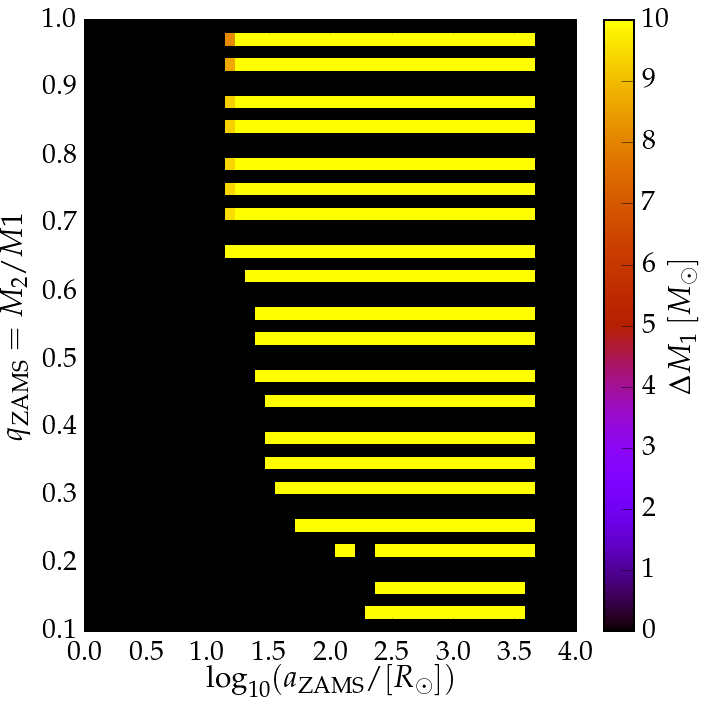

In [16]:
# DM1 only
fname = folder+'TAMS2.data'
FF = open(fname,'r')
for i, line in enumerate(FF):
    if i==0:
	bcol = line.split()
	print "Bound:", bcol
        break
FF.close()

xx = np.linspace(0,4,50)
yy = np.linspace(0.1,1,50)
mat =np.zeros([len(xx),len(yy)])

src = reader(fname,len(bcol),1)

#load data
type1 = src[:,bcol.index('type1')]
type2 = src[:,bcol.index('type2')]
M1 = src[:,bcol.index('M1')]
M2 = src[:,bcol.index('M2')]
M1zams = src[:,bcol.index('M1zams')]
M2zams = src[:,bcol.index('M2zams')]
Pzams = src[:,bcol.index('Pzams')]
Prob = src[:,bcol.index('Prob')]

# #remove mergers:
imerger = type2[:] == 15
type1 = remove_systems(type1,imerger)
type2 = remove_systems(type2,imerger)
M1 = remove_systems(M1,imerger)
M2 = remove_systems(M2,imerger)
M1zams = remove_systems(M1zams,imerger)
M2zams = remove_systems(M2zams,imerger)
Pzams = remove_systems(Pzams,imerger)
Prob = remove_systems(Prob,imerger)

#remove single stars
isingle = Pzams > 1e40
type1 = remove_systems(type1,isingle)
type2 = remove_systems(type2,isingle)
M1 = remove_systems(M1,isingle)
M2 = remove_systems(M2,isingle)
M1zams = remove_systems(M1zams,isingle)
M2zams = remove_systems(M2zams,isingle)
Pzams = remove_systems(Pzams,isingle)
Prob = remove_systems(Prob,isingle)

# calculate initial mass ratio and separation
qzams = M2zams/M1zams
#azams = (215.0/(365.0)**(2/3.0))*((M1zams+M2zams)**(1/3.))*(Pzams)**2/3.0 # in Rsun
#logazams = np.log10(azams)
#logPzams = np.log10(Pzams)
Pzams = Pzams/365.0 # in years
aAUzams = ((M1zams+M2zams)*Pzams*Pzams)**0.33
azams = aAUzams*215
logazams =np.log10(azams)

DM1 = np.array(np.absolute(M1-M1zams),dtype=float)

#print len(qzams), len(logazams),len(beta)

fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
ax = plt.subplot(gs[:,0:90])
ax2 = plt.subplot(gs[:,90:100])

# ax.scatter(#logazams
#            np.log10(Pzams),qzams,c=beta,s=100)

# xx = np.linspace(0.15,3.5,50) # in period
print "entering loop"
for i in xrange(0,len(xx)-1,1):
    for j in xrange(0,len(yy)-1,1):
        #print colored(xx[i],"green"),xx[i+1], yy[j],yy[j+1], min(logPzams),max(logPzams), min(qzams),max(qzams)
        #ip = np.array(logPzams >= xx[i],dtype=bool)*np.array(logPzams<xx[i+1],dtype=bool)
        ip = np.array(logazams >= xx[i],dtype=bool)*np.array(logazams<xx[i+1],dtype=bool)
        iq = np.array(qzams >= yy[j],dtype=bool)*np.array(qzams<yy[j+1],dtype=bool)
        #print colored(iq,"blue")
        #print colored(ip,"red")
        #print len(ip), len(iq), len(ip*iq),len(beta)
        ind = np.array(ip*iq,dtype=bool)
        try:
            avg_DM1=np.average(DM1[ind])#,weights=Prob[ind])
            # print "-------------------"
            # print len(DM1[ind])
            # print max(DM1[ind]),min(DM1[ind])
            # print "-------------------"
        except:
            avg_DM1 = 0
            #print colored(beta[ind],"red")
            #avg_beta=np.average(beta[ind],weights=Prob[ind])
        mat[j,i] = avg_DM1
plot = ax.pcolor(xx,yy,mat,cmap=plt.get_cmap('gnuplot'),vmin=0,vmax=10)
ax.set_ylim(0.1,1)
# ax.set_xlim(0.15,3.5)


fig.colorbar(plot,ax=ax,cax=ax2)
ax2.set_ylabel(r"$\Delta M_1 \ [M_\odot]$",fontsize=30)

ax.set_xlim(0,4)
ax.set_ylabel(r"$q_\mathrm{ZAMS} = M_2/M1$",fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{ZAMS}/ [R_\odot])$",fontsize=30)
#ax.set_xlabel(r"$a_\mathrm{ZAMS} [R_\odot]$",fontsize=30)
#ax.set_xlabel(r"$\log_{10}(P_{ZAMS} /[\mathrm{days}])$",fontsize=30)
#ax.set_xscale('log')
#ax.text(0.15,2.7,str(t),color='w',fontsize=30,transform=ax.transData)            
plt.tight_layout()
plt.show()   
            